# An Alpaca/Not Alpaca classifier by usingTransfer learning (MobileNetV2)

<a name='1'></a>
## 1 - Packages

In [27]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation


<a name='2'></a>
## 2 - Create the Dataset and Split it into Training and Validation Sets

In [28]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 330 files belonging to 2 classes.
Using 264 files for training.
Found 330 files belonging to 2 classes.
Using 66 files for validation.


In [29]:
class_names = train_dataset.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

['alpaca', 'not alpaca']


In [30]:
class_names1 = validation_dataset.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in validation_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

['alpaca', 'not alpaca']


<a name='3'></a>
## 3 - Preprocess and Augment Training Data

Using `prefetch()` prevents a memory bottleneck that can occur when reading from disk. It sets aside some data and keeps it ready for when it's needed, by creating a source dataset from your input data, applying a transformation to preprocess it, then iterating over the dataset one element at a time. Because the iteration is streaming, the data doesn't need to fit into memory.

Using `tf.data.experimental.AUTOTUNE` to choose the parameters automatically. Autotune prompts `tf.data` to tune that value dynamically at runtime, by tracking the time spent in each operation and feeding those times into an optimization algorithm. The optimization algorithm tries to find the best allocation of its CPU budget across all tunable operations. 

In [31]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

<a name='3.1'></a>
### Data Augmentation

In [32]:
def data_augmenter():
    
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'))
    data_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomRotation(0.2))
    
    return data_augmentation

<a name='3.2'></a>
### Show Augmented Image

In [33]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(15,15))
    first_image = image[2]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] /255)
        plt.axis('off')

In [34]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

<a name='4'></a>
## 4 - Using MobileNetV2 for Transfer Learning 

MobileNetV2 was trained on ImageNet and is optimized to run on mobile and other low-power applications. It's 155 layers deep and very efficient for object detection and image segmentation tasks, as well as classification tasks like this one. The architecture has three defining characteristics:

*   Depthwise separable convolutions
*   Thin input and output bottlenecks between layers
*   Shortcut connections between bottleneck layers

<b>Note:</b>  MobileNet pretrained over ImageNet doesn't have the correct labels for alpacas, so when we use the full model, all we will get a bunch of incorrectly classified images.
So, we have to delete the top layer, which contains all the classification labels, and create a new classification layer.

In [35]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
   
    input_shape = image_shape + (3,)
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, 
                                                   weights='imagenet') # From imageNet
    
    # Freezimg the base model by making it non trainable
    base_model.trainable = False

    # creating the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=(160, 160, 3)) 

    x = data_augmentation(inputs)
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    x=tf.keras.layers.Dropout(0.2)(x)
    prediction_layer=tf.keras.layers.Dense(1,activation="sigmoid")
    
    outputs = prediction_layer(x) 
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [36]:
model = alpaca_model(IMG_SIZE, data_augmentation)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0   

In [37]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
nb_layers = len(model.layers)
nb_layers

8

In [39]:
initial_epochs = 10
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/10
9/9 [==============================] - 26s 1s/step - loss: 0.8159 - accuracy: 0.4811 - val_loss: 0.5736 - val_accuracy: 0.7121
Epoch 2/10
9/9 [==============================] - 9s 835ms/step - loss: 0.6511 - accuracy: 0.6439 - val_loss: 0.4175 - val_accuracy: 0.8788
Epoch 3/10
9/9 [==============================] - 10s 916ms/step - loss: 0.5406 - accuracy: 0.7576 - val_loss: 0.3580 - val_accuracy: 0.8788
Epoch 4/10
9/9 [==============================] - 10s 949ms/step - loss: 0.4795 - accuracy: 0.7538 - val_loss: 0.3333 - val_accuracy: 0.8939
Epoch 5/10
9/9 [==============================] - 10s 903ms/step - loss: 0.4222 - accuracy: 0.7917 - val_loss: 0.2884 - val_accuracy: 0.8939
Epoch 6/10
9/9 [==============================] - 9s 859ms/step - loss: 0.3680 - accuracy: 0.8561 - val_loss: 0.2386 - val_accuracy: 0.9091
Epoch 7/10
9/9 [==============================] - 9s 797ms/step - loss: 0.3767 - accuracy: 0.8295 - val_loss: 0.2490 - val_accuracy: 0.9091
Epoch 8/10
9/9 [===

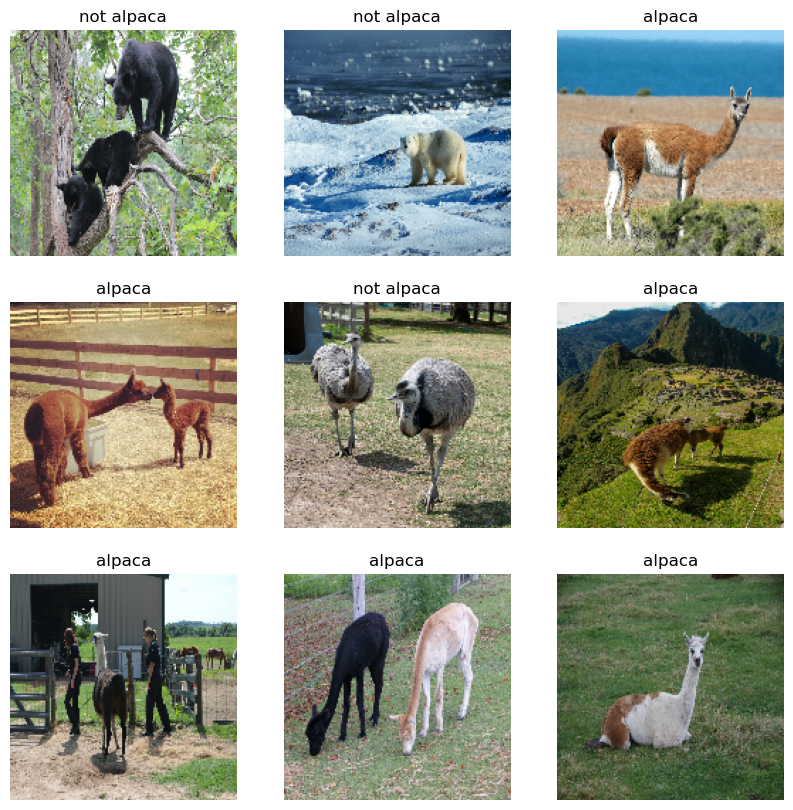

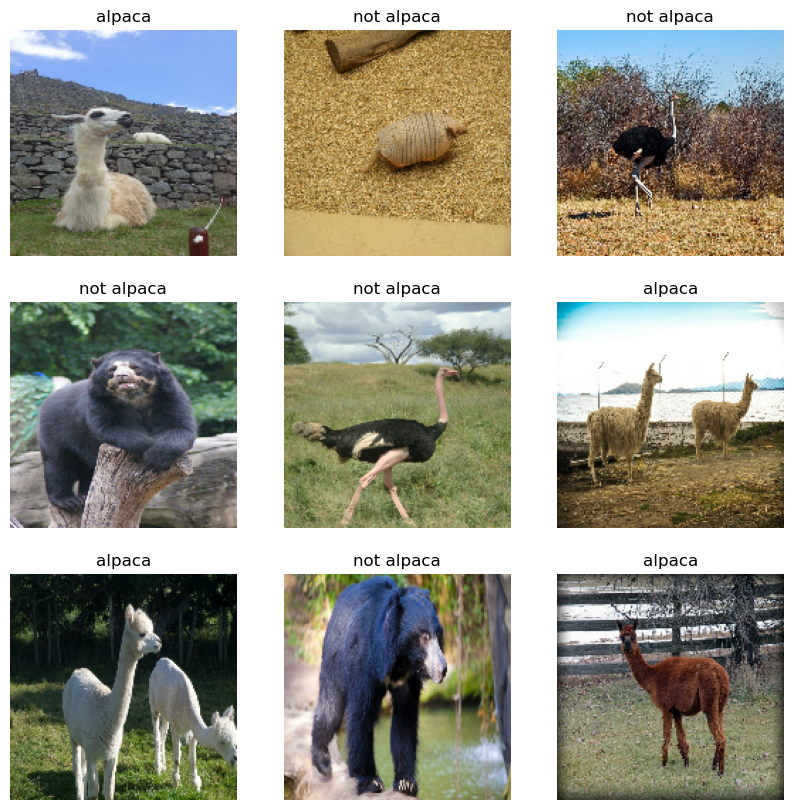

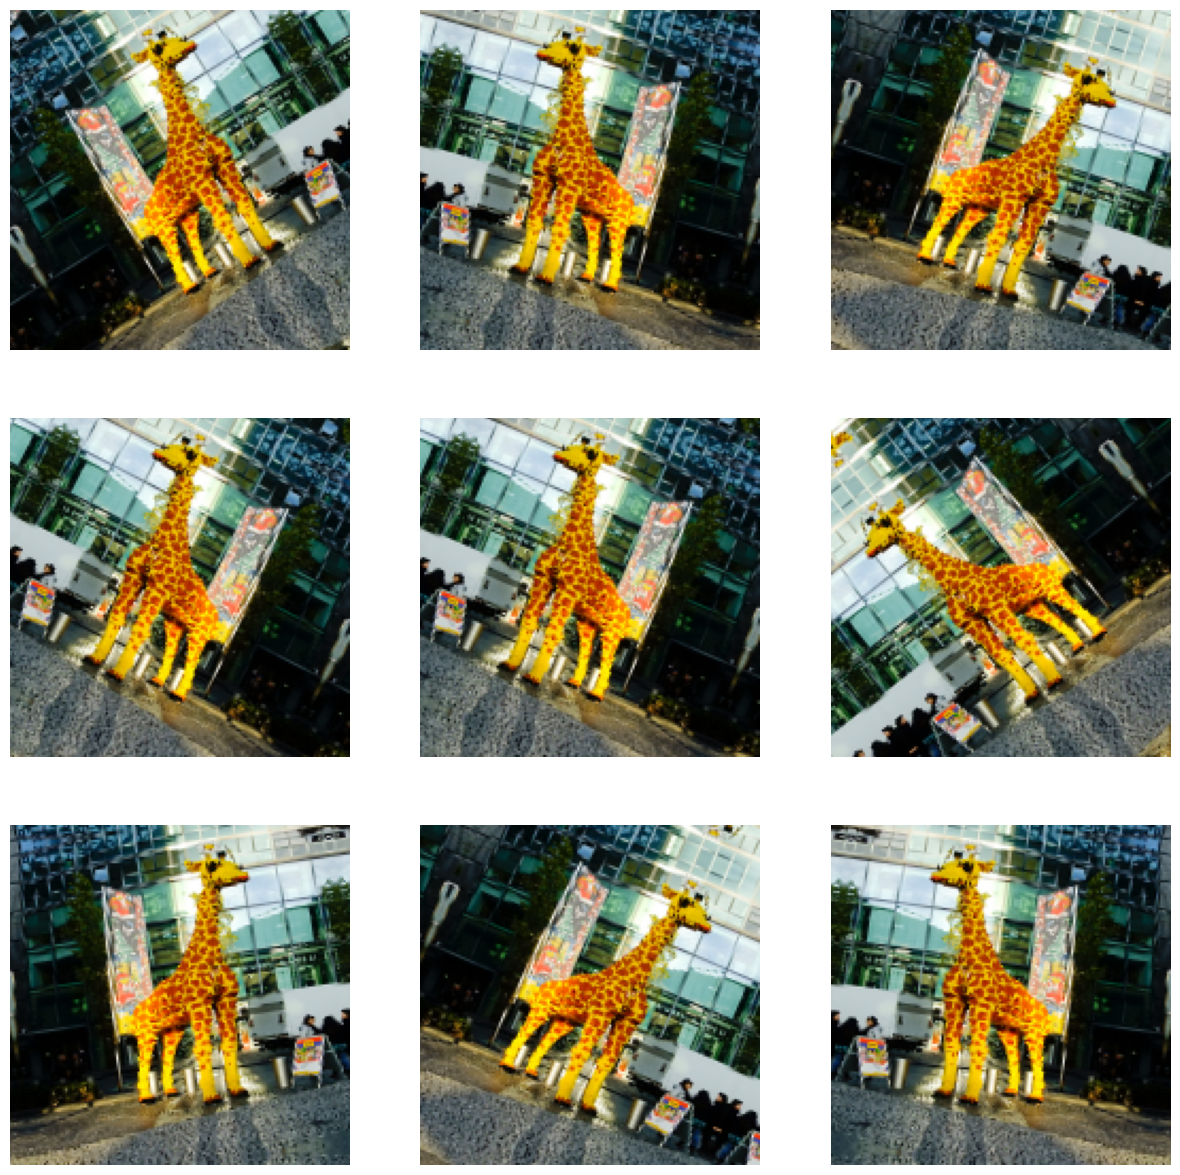

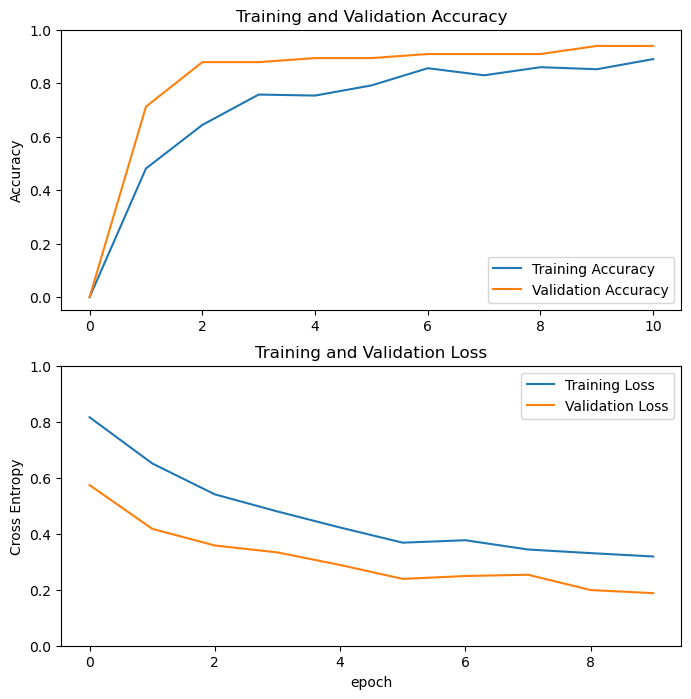

In [40]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<a name='5'></a>
## 5- Fine-tuning the Model

In [41]:
base_model = model.layers[4]
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

loss_function=tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(lr=0.1*base_learning_rate)
metrics=['accuracy']

model.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  154


In [42]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
9/9 [==============================] - 38s 2s/step - loss: 0.5006 - accuracy: 0.7614 - val_loss: 0.2494 - val_accuracy: 0.9242
Epoch 11/20
9/9 [==============================] - 16s 1s/step - loss: 0.2991 - accuracy: 0.8750 - val_loss: 0.1750 - val_accuracy: 0.9394
Epoch 12/20
9/9 [==============================] - 13s 1s/step - loss: 0.1978 - accuracy: 0.9318 - val_loss: 0.1554 - val_accuracy: 0.9091
Epoch 13/20
9/9 [==============================] - 12s 1s/step - loss: 0.2816 - accuracy: 0.8561 - val_loss: 0.1090 - val_accuracy: 0.9545
Epoch 14/20
9/9 [==============================] - 13s 1s/step - loss: 0.2265 - accuracy: 0.9129 - val_loss: 0.1232 - val_accuracy: 0.9545
Epoch 15/20
9/9 [==============================] - 13s 1s/step - loss: 0.1325 - accuracy: 0.9508 - val_loss: 0.2041 - val_accuracy: 0.9091
Epoch 16/20
9/9 [==============================] - 12s 1s/step - loss: 0.1538 - accuracy: 0.9167 - val_loss: 0.1090 - val_accuracy: 0.9697
Epoch 17/20
9/9 [==========

In [43]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

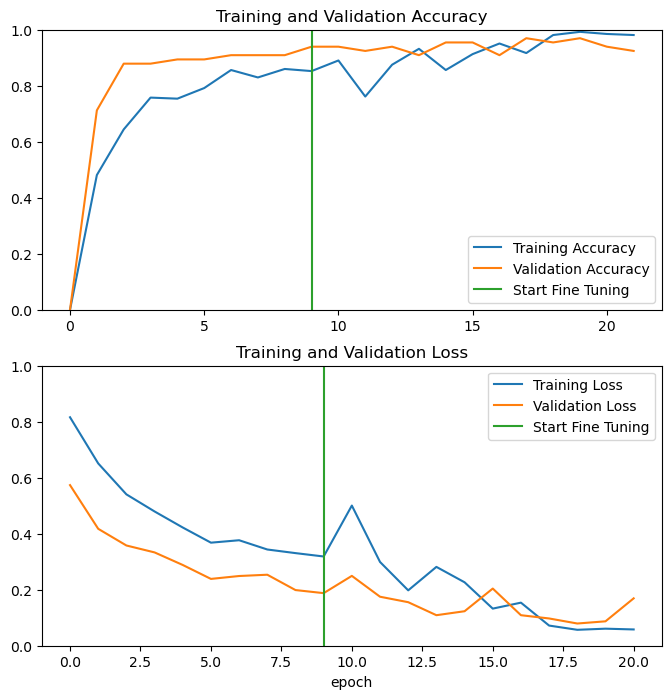

In [44]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [45]:
nb_layers = len(model.layers)
print(model.layers[nb_layers - 4].name)
print(model.layers[nb_layers - 3].name)
print(model.layers[nb_layers - 2].name)
print(model.layers[nb_layers - 1].name)
print(nb_layers)

mobilenetv2_1.00_160
global_average_pooling2d_1
dropout_1
dense_1
8


In [46]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0   

In [47]:
image_batch, label_batch = next(iter(train_dataset))

feature_batch = model(image_batch)
print(feature_batch.shape)
feature_batch

(32, 1)


<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[4.1965842e-03],
       [9.7497237e-01],
       [5.8319715e-06],
       [9.6260989e-01],
       [9.9973953e-01],
       [9.9884629e-01],
       [9.6546668e-01],
       [9.8717582e-01],
       [9.9903333e-01],
       [9.6993268e-01],
       [1.3220310e-04],
       [2.2880733e-03],
       [5.8923399e-01],
       [9.1868639e-04],
       [1.0560155e-03],
       [9.9920857e-01],
       [1.2140870e-03],
       [2.9763072e-05],
       [9.9169600e-01],
       [9.9992085e-01],
       [5.5451155e-02],
       [9.9844062e-01],
       [5.8332898e-06],
       [9.0888691e-01],
       [5.5938731e-06],
       [9.0867390e-05],
       [9.8309147e-01],
       [9.9476480e-01],
       [9.6133590e-01],
       [8.7505591e-01],
       [9.7829348e-01],
       [9.9976277e-01]], dtype=float32)>

In [48]:
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1])>

In [51]:
#model.trainable = False
#image_var = tf.Variable(image_batch)
#pred = model(image_var)
m=model.predict(train_dataset)
m
#tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

array([[9.99969959e-01],
       [1.54763460e-04],
       [9.99617100e-01],
       [2.79886171e-06],
       [1.59252443e-06],
       [9.83436406e-01],
       [5.56304894e-06],
       [4.38207026e-05],
       [9.99751925e-01],
       [5.82765341e-02],
       [9.95554924e-01],
       [9.99855876e-01],
       [9.87174869e-01],
       [9.99986529e-01],
       [7.87542958e-05],
       [1.02860147e-04],
       [6.19119406e-03],
       [9.94991064e-01],
       [9.99489129e-01],
       [4.64826962e-06],
       [9.99912381e-01],
       [5.93250945e-07],
       [9.78526115e-01],
       [9.98630464e-01],
       [2.56747007e-04],
       [4.20474171e-05],
       [8.44725966e-02],
       [3.80207041e-07],
       [9.95211244e-01],
       [1.39701068e-02],
       [9.98462915e-01],
       [9.92754817e-01],
       [9.99975622e-01],
       [9.99120533e-01],
       [9.73052680e-01],
       [9.22973037e-01],
       [6.22593288e-05],
       [2.10893154e-03],
       [2.90035459e-05],
       [7.52861342e-06],
